In [1]:
!pip install albumentations

In [2]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2

In [3]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_names = []
    for boxes in root.iter('object'):

        classname = boxes.find('name').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        
        list_names.append(classname)

    return list_names, list_with_all_boxes

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    #x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)        

In [4]:
imgdir = "Small_Set/Train/"
labdir = "Small_Set/Train_Label/"
outimgdir = "Small_Set/Output_Train/"
outlabdir  = "Small_Set/Output_Train/"
img_size = 416
import glob
img_names = glob.glob(imgdir + "*.jpg")
label_names = glob.glob(labdir+ "*.xml")
img_names.sort()
label_names.sort()
print(img_names[0] + " " + label_names[0])

Small_Set/Train/6_387.jpg Small_Set/Train_Label/6_387.xml


In [5]:
class_labels, bboxes = read_content(label_names[0])
bboxes

[[1606, 343, 2548, 917],
 [1457, 1201, 2203, 1859],
 [2354, 1453, 2935, 2130],
 [822, 1469, 1315, 2243]]

In [6]:
class_labels

['6', '6', '6', '6']

In [7]:
image = cv2.imread(img_names[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

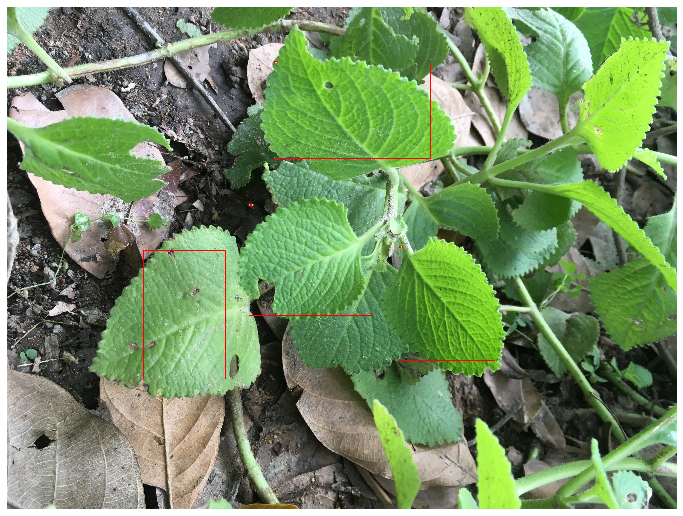

In [8]:
category_id_to_name = {'6': 'Herb'}
visualize(image, bboxes, class_labels, category_id_to_name)

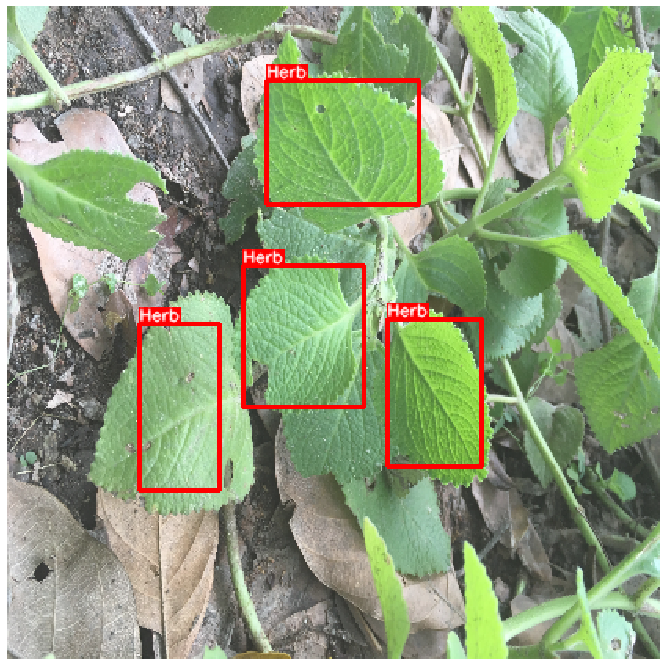

In [9]:
category_id_to_name = {'6': 'Herb'}

train_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.25, rotate_limit=45, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.2))

transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
visualize(transformed_image, transformed_bboxes, transformed_class_labels, category_id_to_name)

In [10]:
for i in range(len(img_names)):
    image = cv2.imread(img_names[i])
    class_labels, bboxes = read_content(label_names[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    onlyname = img_names[i].split('/')[-1].split('.')[0]
    for ii in range(10):
        transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']
        transformed_name = onlyname+'_'+str(ii)
        cv2.imwrite(outimgdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
        out_file = open(outlabdir + transformed_name +'.txt', 'w')
        for iii in range(len(transformed_bboxes)):
            x_min, y_min, x_max, y_max = transformed_bboxes[iii]
            b = (x_min, x_max, y_min, y_max)
            out_file.write(str(0) + " " + " ".join([str(a) for a in convert((img_size,img_size),b)]) + '\n')
        out_file.close()

In [11]:
imgdir = "Small_Set/Validation/"
labdir = "Small_Set/Validation_Label/"
outimgdir = "Small_Set/Output_Val/"
outlabdir  = "Small_Set/Output_Val/"
import glob
img_names = glob.glob(imgdir + "*.jpg")
label_names = glob.glob(labdir+ "*.xml")
img_names.sort()
label_names.sort()
print(img_names[0] + " " + label_names[0])

Small_Set/Validation/6_437.jpg Small_Set/Validation_Label/6_437.xml


In [12]:
train_transform = A.Compose([
    A.Resize(width=img_size, height=img_size),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.2))

In [13]:
for i in range(len(img_names)):
    image = cv2.imread(img_names[i])
    class_labels, bboxes = read_content(label_names[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    onlyname = img_names[i].split('/')[-1].split('.')[0]

    transformed = train_transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']
    transformed_name = onlyname
    cv2.imwrite(outimgdir + transformed_name +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)) 
    out_file = open(outlabdir + transformed_name +'.txt', 'w')
    for iii in range(len(transformed_bboxes)):
        x_min, y_min, x_max, y_max = transformed_bboxes[iii]
        b = (x_min, x_max, y_min, y_max)
        out_file.write(str(0) + " " + " ".join([str(a) for a in convert((img_size,img_size),b)]) + '\n')
    out_file.close()